In [1]:
import torch
import matplotlib.pyplot as plt 
import numpy as np 

import torchvision
import torchvision.transforms as transforms 

import torch.nn as nn
import torch.optim as optim
import seaborn as sns


## Dataset and Visualisation

In [17]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
download=True, transform=transforms.ToTensor())

In [19]:
batch_size = 4


In [20]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

In [21]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
2


In [22]:
def imshow(img, title):
    plt.figure(figsize=(batch_size*4,4))
    plt.axis('off')
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.title(title)
    plt.show()

In [23]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))

    img = torchvision.utils.make_grid(images)
    imshow(img,title=[str(x.item()) for x in labels])

    return images, labels

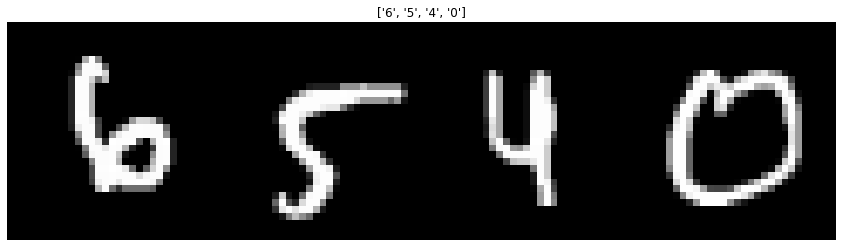

In [24]:
images, labels = show_batch_images(trainloader)

## Batchnorm

In [25]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.ReLU(),
            nn.Linear(48,24),
            nn.ReLU(),
            nn.Linear(24,10)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [26]:
class MyNetBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784,48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48,24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [27]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [28]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [29]:
batch_size = 512

In [30]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)

In [31]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = 0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

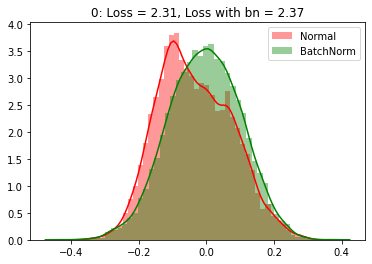

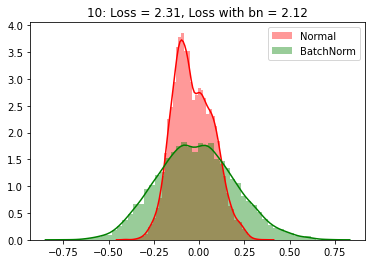

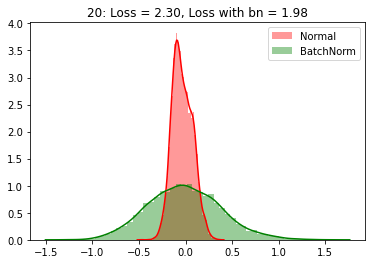

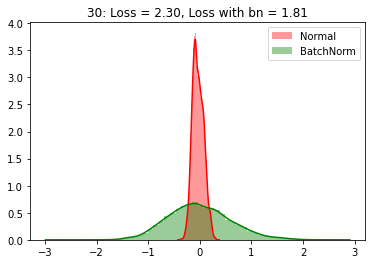

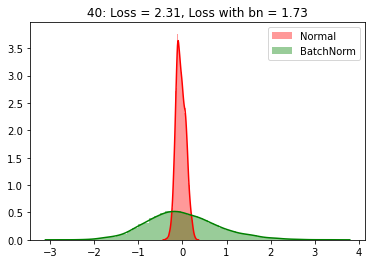

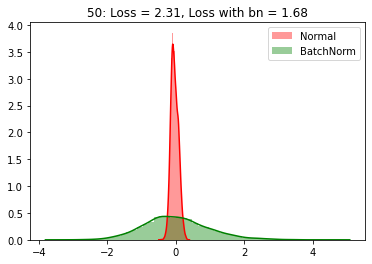

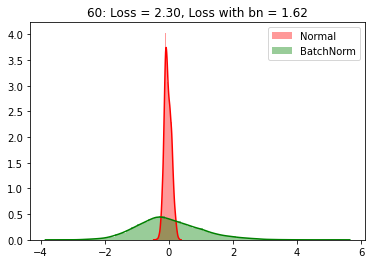

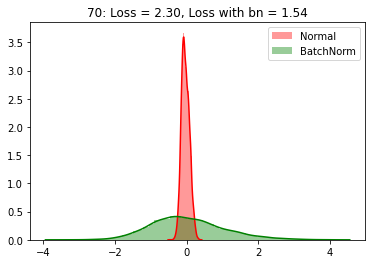

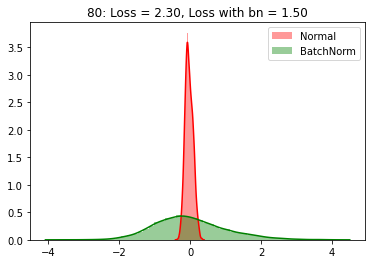

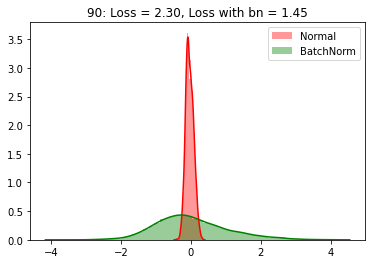

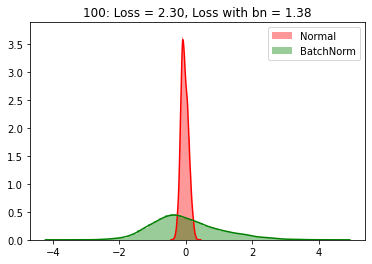

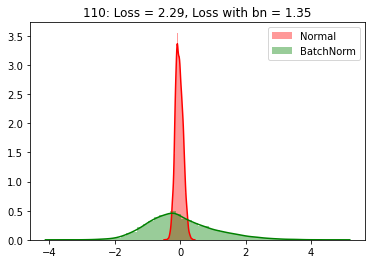

------------------------------------


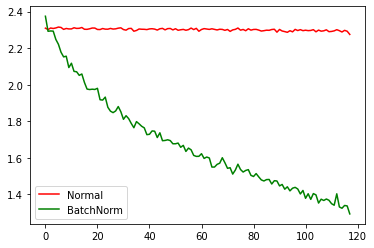

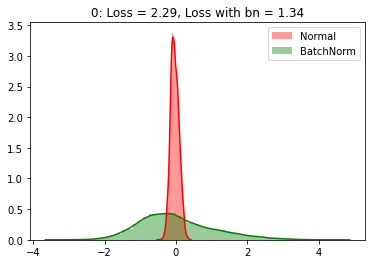

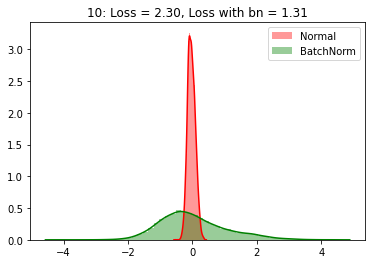

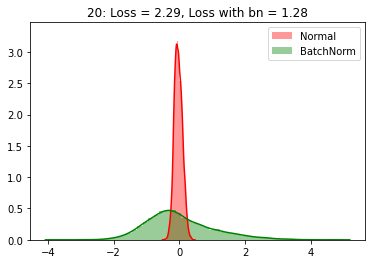

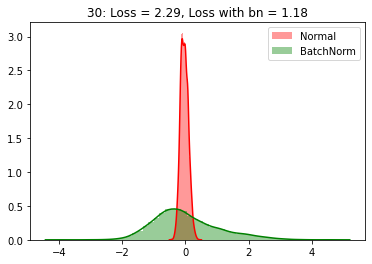

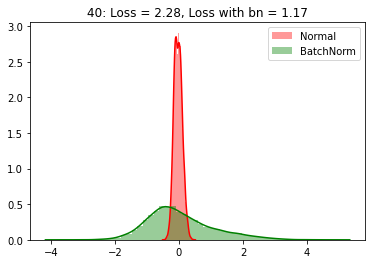

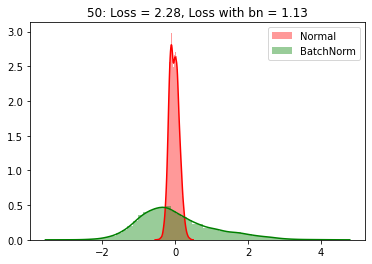

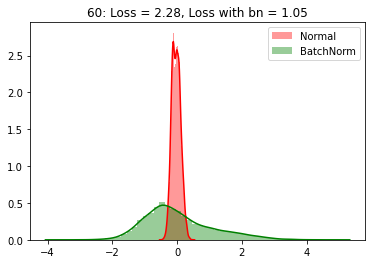

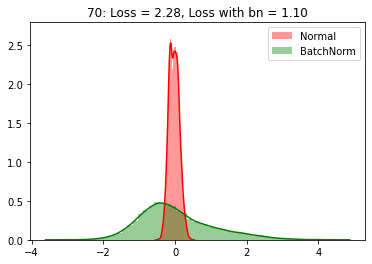

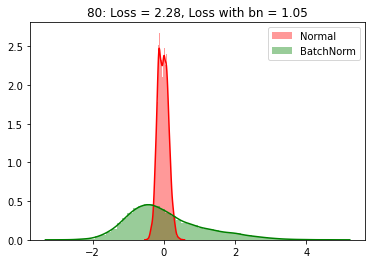

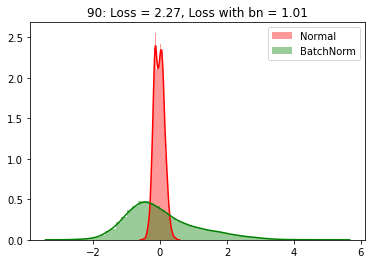

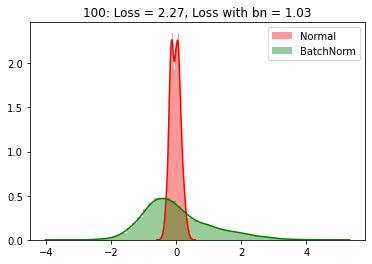

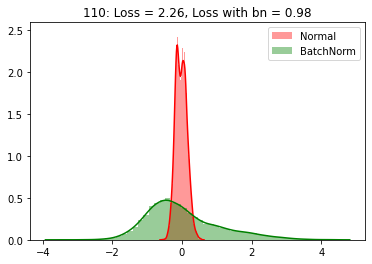

------------------------------------


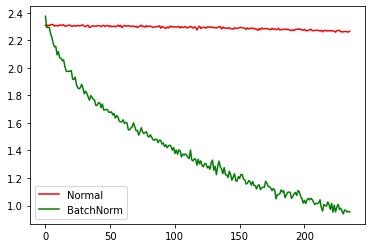

In [32]:
loss_arr = []
loss_bn_arr = []

max_epoch = 2

for epoch in range(max_epoch):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

        if i%10 == 0:
            inputs = inputs.view(inputs.size(0), -1)

            model.eval()
            model_bn.eval()

            a = model.classifier[0](inputs)
            a = model.classifier[1](a)
            a = model.classifier[2](a)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r',label='Normal')


            b = model_bn.classifier[0](inputs)
            b =  model_bn.classifier[1](b)
            b =  model_bn.classifier[2](b)
            b =  model_bn.classifier[3](b)
            b =  model_bn.classifier[4](b)
            b =  b.detach().numpy().ravel()

            sns.distplot(b, kde=True, color='g', label='BatchNorm')
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' %(i,loss.item(),loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)

            model.train()
            model_bn.train()

    print('------------------------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr,'g',label='BatchNorm')
    plt.legend()
    plt.show()

In [33]:
class CNN_BN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6)           # (N, 3, 12, 12) -> (N,  6, 10, 10) 
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),         # (N, 150) -> (N, 25)
            nn.ReLU(),
            nn.Linear(25,10)            # (N, 25) -> (N, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## DROP OUT

In [34]:
N = 50
noise = 0.3 

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

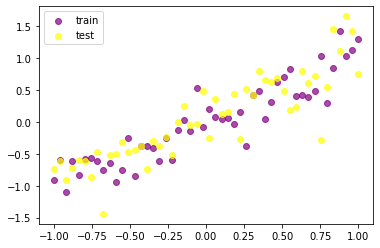

In [44]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha = 0.7, label = 'train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.7, label='test')
plt.legend()
plt.show()

In [57]:
N_h = 100

model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1)
)

In [58]:
opt = torch.optim.Adam(model.parameters(), lr = 0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

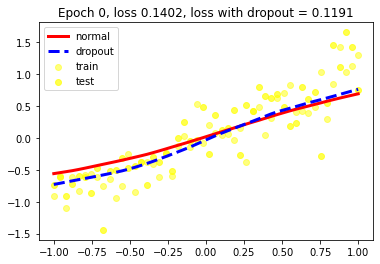

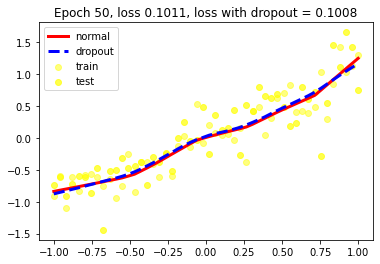

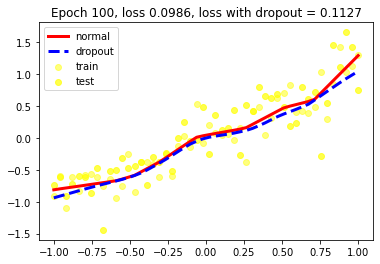

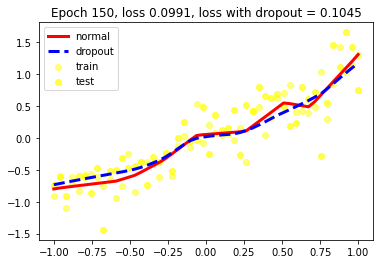

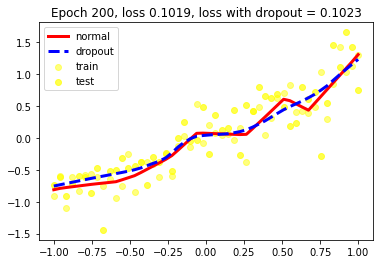

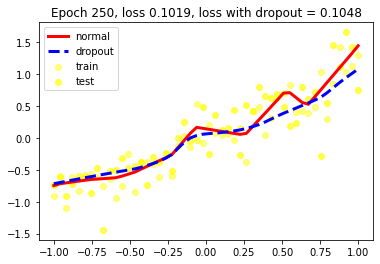

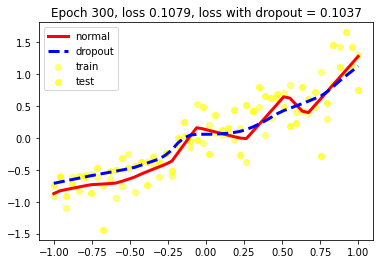

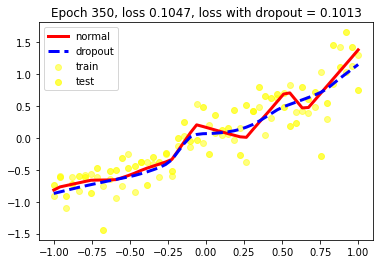

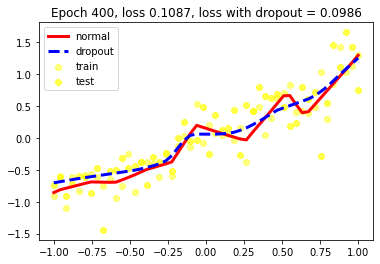

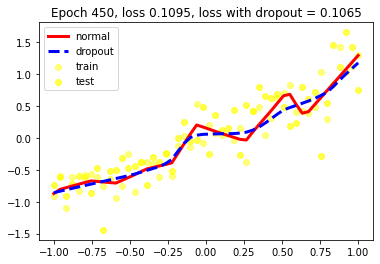

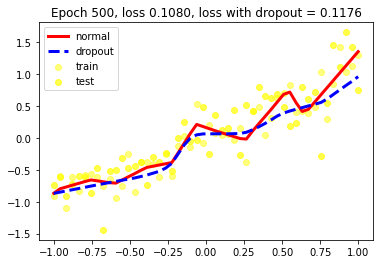

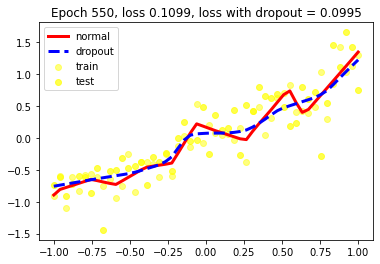

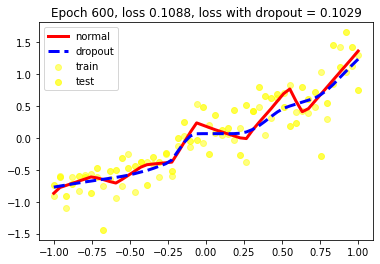

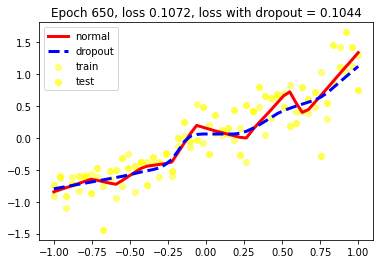

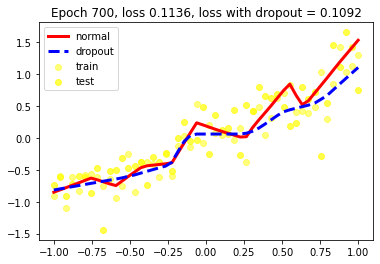

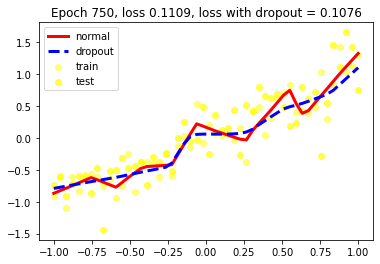

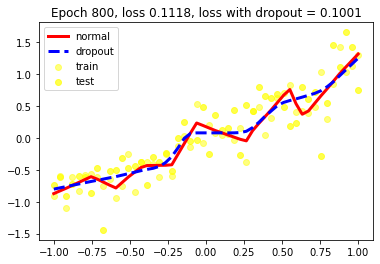

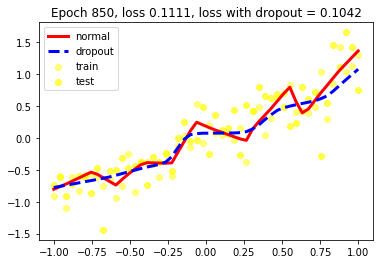

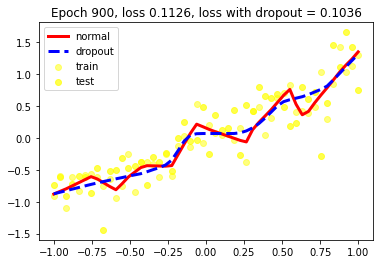

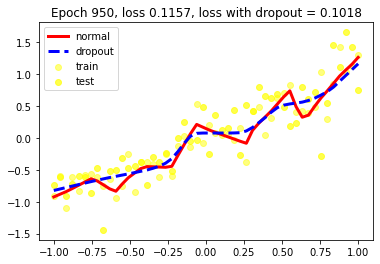

In [59]:
max_epochs = 1000

for epoch in range(max_epochs):
    pred = model(X_train)
    loss = loss_fn(pred, Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0:
        model.eval()
        model_dropout.eval()

        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, Y_test)

        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='yellow', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.7, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(),'r-',lw=3, label='normal')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(),'b--', lw=3, label='dropout')

        plt.title("Epoch %d, loss %0.4f, loss with dropout = %0.4f" %(epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)
